# 🧪 Custom Stacking Regression

In this notebook, we implement a stacking ensemble regressor **from scratch** using base regressors and a meta-model. We then compare the performance of these implementations with **scikit-learn**'s `StackingRegressor` model.

### ⚙️ Importing Libraries & Environment Setup

In [29]:
from copy import deepcopy
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [30]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [31]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, R2) for each model.
            Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(columns=predictions.keys(), index=["MAE", "MSE", "R2"])

    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        evaluations.loc[:, name] = [mae, mse, r2]

    return evaluations.astype(float)

In [32]:
def plot_regression_models(
    predictions: dict[str, NDArray[np.float64]],
    X: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
) -> None:
    """Plot regression results for multiple models on scatter data.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted values for X_test.
        X (NDArray[np.float64]): Original feature data of shape (n_samples, 1)
            for scatter plot.
        y (NDArray[np.float64]): True target values corresponding to X.
        X_test (NDArray[np.float64]): Feature values where predictions are
            evaluated and plotted.
    """
    sns.scatterplot(x=X.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")

    palette = sns.color_palette("Set1")
    for index, (name, y_pred) in enumerate(predictions.items()):
        sns.lineplot(
            x=X_test.flatten(),
            y=y_pred.flatten(),
            alpha=0.6,
            color=palette[index],
            label=name,
        )

    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [33]:
# Generate dataset
X, y = make_regression(
    n_samples=100, n_features=1, noise=10, bias=37.0, random_state=42
)

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [35]:
class MyStackingRegressor:
    """Stacking ensemble regressor.

    Combines multiple base estimators by training them on the original dataset,
    then uses their out-of-fold predictions as input features for a final estimator.
    This approach leverages the strengths of diverse models and often improves
    predictive performance.

    Attributes:
        estimators (list[tuple[str, Any]]): List of (name, estimator) tuples as
            base models.
        final_estimator (Any): The meta-estimator that aggregates base estimators'
            predictions.
        cv (int): Number of folds for cross-validation used to generate out-of-fold
            predictions.
        random_state (int): Seed for reproducibility.
        base_estimators_ (list[Any] | None): Fitted clones of the base estimators.
        final_estimator_ (Any | None): Fitted final meta-estimator.
    """

    def __init__(
        self,
        estimators: list[tuple[str, Any]],
        final_estimator: Any,
        cv: int = 5,
        random_state: int = 42,
    ) -> None:
        """Initialize the stacking regressor.

        Args:
            estimators (list[tuple[str, Any]]): Base estimators as (name, estimator)
                pairs.
            final_estimator (Any): Meta-estimator to combine base predictions.
            cv (int, optional): Number of cross-validation folds for out-of-fold
                predictions. Defaults to 5.
            random_state (int, optional): Seed for random number generation.
                Defaults to 42.
        """
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.random_state = random_state

        self.base_estimators_: list[Any] | None = None
        self.final_estimator_: Any = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Fit the stacking regressor.

        Trains base estimators using cross-validation to generate out-of-fold
        predictions which are then used as features to train the final meta-estimator.

        Args:
            X (NDArray[np.float64]): Training input data, shape (n_samples, n_features).
            y (NDArray[np.float64]): Target values, shape (n_samples,).
        """
        self.base_estimators_ = [deepcopy(est[1]) for est in self.estimators]
        self.final_estimator_ = deepcopy(self.final_estimator)

        n_samples = X.shape[0]
        n_estimators = len(self.base_estimators_)
        meta_features = np.zeros((n_samples, n_estimators))

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

        for i, estimator in enumerate(self.base_estimators_):
            oof_preds = np.zeros(n_samples)
            for train_idx, valid_idx in kf.split(X):
                estimator.fit(X[train_idx], y[train_idx])
                oof_preds[valid_idx] = estimator.predict(X[valid_idx])
            meta_features[:, i] = oof_preds

            estimator.fit(X, y)

        self.final_estimator_.fit(meta_features, y)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values for samples in X.

        Args:
            X (NDArray[np.float64]): Input data, shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values.
        """
        meta_features = np.column_stack(
            [est.predict(X) for est in self.base_estimators_]
        )
        return self.final_estimator_.predict(meta_features)

### 🏋️‍♂️ Model Training

In [36]:
# Base models
base_estimators = [
    ("knn", KNeighborsRegressor(n_neighbors=5)),
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
]

final_estimator = LinearRegression()

# Scikit-learn linear regression model
sklearn_linear_model = deepcopy(final_estimator)
sklearn_linear_model.fit(X_train, y_train)

# Scikit-learn stacking regressor model
sklearn_model = StackingRegressor(
    estimators=base_estimators, final_estimator=final_estimator
)
sklearn_model.fit(X_train, y_train)

# My stacking regressor model
my_model = MyStackingRegressor(
    estimators=base_estimators, final_estimator=final_estimator
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [37]:
predictions = {
    "scikit-learn_linear": sklearn_linear_model.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [38]:
evaluate_regression_models(predictions, y_test)

,scikit-learn_linear,scikit-learn,my
MAE,8.416660,9.623612,9.220344
MSE,104.202227,130.436308,122.435627
R2,0.937415,0.921659,0.926464


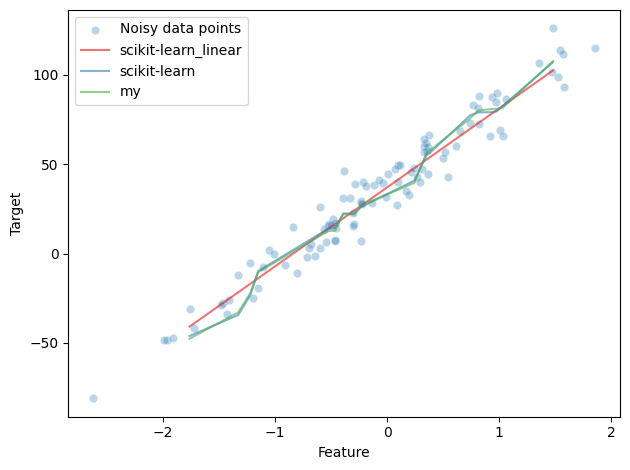

In [39]:
plot_regression_models(predictions, X, y, X_test)